# Sydney Analysis

## Setup

In [123]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [124]:
db, conn = pgconnect(credentials)
query(conn, "select PostGIS_Version()")

Connected successfully.


,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### Setting Search Path

In [125]:
conn.execute("set search_path to public")

## Imports

In [126]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

## Cleaning function for positive columns

In [127]:
def invalid_col(df, pos_num_columns):
    invalid = 1
    for i in range(len(pos_num_columns)):
        if len(df[df[pos_num_columns[i]] < 0]) > 0:
            print(f"{pos_num_columns[i]} invalid")
            invalid = 0

    if invalid == 1:
        print(f"All columns that should have positive numbers have correct data, i.e. {pos_num_columns}")

## Reading in and cleaning SA2

In [128]:
SA2 = gpd.read_file("SA2/SA2_2016_AUST.shp")
SA2og = SA2.copy()

SA2 = SA2[SA2['GCC_NAME16'] == "Greater Sydney"]

# Testing for duplicate rows
if (SA2.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    SA2[SA2.duplicated(keep=False)]
    
#Testing for Null values
if (SA2.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    SA2[SA2.isnull().any(axis=1)]

pos_num_col = ['AREASQKM16']
invalid_col(SA2, pos_num_col) 

SA2.rename(columns={
    'SA2_MAIN16' : 'sa2_main16',
    'SA2_5DIG16' : 'sa2_5dig16',
    'SA2_NAME16' : 'sa2_name16',
    'SA3_CODE16' : 'sa3_code16',
    'SA3_NAME16' : 'sa3_name16',
    'SA4_CODE16' : 'sa4_code16',
    'SA4_NAME16' : 'sa4_name16',
    'GCC_CODE16' : 'gcc_code16',
    'GCC_NAME16' : 'gcc_name16',
    'STE_CODE16' : 'ste_code16',
    'STE_NAME16' : 'ste_name16',
    'AREASQKM16' : 'areasqkm16'
}, inplace = True)

SA2['geom'] = SA2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  
SA2 = SA2.drop(columns="geometry") 

No duplicated rows
No Null values
All columns that should have positive numbers have correct data, i.e. ['AREASQKM16']


In [134]:
conn.execute("""
DROP TABLE IF EXISTS sa2 CASCADE;
CREATE TABLE sa2 (
    sa2_main16 INT UNIQUE,
    sa2_5dig16 INT,
    sa2_name16 VARCHAR(80) UNIQUE,
    sa3_code16 INT,
    sa3_name16 VARCHAR(80),
    sa4_code16 INT,
    sa4_name16 VARCHAR(80),
    gcc_code16 CHAR(5),
    gcc_name16 VARCHAR(80),
    ste_code16 INT,
    ste_name16 VARCHAR(80),
    areasqkm16 NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283),
    PRIMARY KEY(sa2_main16, sa2_name16)
);"""
)

SA2.to_sql("sa2", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

## Reading in and Cleaning Neighbourhoods

In [130]:
rawData = pd.read_csv('Neighbourhoods.csv', thousands=',')
neighbours_data = rawData.copy()

# Replace whitespace with 0
neighbours_data = neighbours_data.replace(r'^\s*$', 0, regex=True)

# Confirm data format
neighbours_data[pd.to_numeric(neighbours_data["population"], errors='coerce').isnull()]
neighbours_data['young_people'] = neighbours_data.iloc[:, -4:-1].sum(axis=1)

neighbours_data = neighbours_data.drop(neighbours_data.columns[[0, 9, 10, 11, 12]], axis=1)  # df.columns is zero-based pd.Index
neighbours_data = neighbours_data.loc[neighbours_data['population'] > 500]
neighbours_data = neighbours_data.loc[neighbours_data['young_people'] > 0]

#Testing for duplicate rows
if (neighbours_data.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    neighbours_data[neighbours_data.duplicated(keep=False)]

    
#Testing for Null values
if (neighbours_data.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    neighbours_data[neighbours_data.isnull().any(axis=1)]
    
neighbours_data = neighbours_data[neighbours_data['area_id'].isin(SA2['sa2_main16'])]


No duplicated rows
No Null values


In [135]:
conn.execute("""
DROP TABLE IF EXISTS neighbours CASCADE;
CREATE TABLE neighbours (
    area_id INT REFERENCES sa2(sa2_main16),
    area_name VARCHAR(50) REFERENCES sa2(sa2_name16),
    land_area NUMERIC,
    population INT,
    number_of_dwellings INT,
    number_of_businesses INT,
    median_annual_household_income INT,
    avg_monthly_rent INT,
    young_people NUMERIC,
    PRIMARY KEY(area_id, area_name)
);"""
)

neighbours_data.to_sql("neighbours", conn, if_exists='append', index=False)

## Reading in and Cleaning Business Stats

In [136]:
busStatRaw = pd.read_csv('BusinessStats.csv')
busStat = busStatRaw.copy()

Check for duplicates; any NaN values; if counts have any negative values (which would be invalid)

In [137]:
#Testing for duplicate rows

if (busStat.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    busStat[busStat.duplicated(keep=False)]
    
#Testing for Null values
if (busStat.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    busStat[busStat.isnull().any(axis=1)]
    

#Testing for inproper data ranges
pos_num_columns = ['number_of_businesses',
           'accommodation_and_food_services',
           'retail_trade',
           'agriculture_forestry_and_fishing',
           'health_care_and_social_assistance',
           'public_administration_and_safety',
           'transport_postal_and_warehousing']

invalid_col(busStat, pos_num_columns)

columns_to_drop = ['number_of_businesses', 
                   'agriculture_forestry_and_fishing',
                   'transport_postal_and_warehousing']

busStat = busStat.drop(columns = columns_to_drop)

busStat = busStat[busStat['area_id'].isin(SA2['sa2_main16'])]


No duplicated rows
No Null values
All columns that should have positive numbers have correct data, i.e. ['number_of_businesses', 'accommodation_and_food_services', 'retail_trade', 'agriculture_forestry_and_fishing', 'health_care_and_social_assistance', 'public_administration_and_safety', 'transport_postal_and_warehousing']


In [138]:
conn.execute("""
DROP TABLE IF EXISTS busstat;
CREATE TABLE busstat (
    area_id INT REFERENCES sa2(sa2_main16),
    area_name VARCHAR(80) REFERENCES sa2(sa2_name16),
    accommodation_and_food_services INT,
    retail_trade INT,
    health_care_and_social_assistance INT,
    public_administration_and_safety INT,
    PRIMARY KEY(area_id, area_name)
);"""
)

busStat.to_sql("busstat", con=conn, if_exists='append', index=False)

## WKT conversion

In [139]:
srid = 4283
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    if geom.geom_type == 'Point Z':
        geom = Point([geom])
    return WKTElement(geom.wkt, srid)

## Reading in and cleaning Break and Enter

In [140]:
bAndE_dwellings = gpd.read_file("Break_and_Enter/BreakEnterDwelling_JanToDec2021.shp")
bAndE_dwellingsog = bAndE_dwellings.copy()

#Testing for duplicate rows
if (bAndE_dwellings.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    bAndE_dwellings[bAndE_dwellings.duplicated(keep=False)]

    
#Testing for Null values
if (bAndE_dwellings.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    bAndE_dwellings[bAndE_dwellings.isnull().any(axis=1)]
    
pos_num_columns = ['Shape_Leng', 'Shape_Area']
invalid_col(bAndE_dwellings, pos_num_columns)

columns_to_drop = ['ORIG_FID', 'Contour']
bAndE_dwellings = bAndE_dwellings.drop(columns = columns_to_drop)
bAndE_dwellings['geom'] = bAndE_dwellings['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  
bAndE_dwellings = bAndE_dwellings.drop(columns="geometry") 

No duplicated rows
No Null values
All columns that should have positive numbers have correct data, i.e. ['Shape_Leng', 'Shape_Area']


In [141]:
bAndE_dwellings.rename(columns={
    'OBJECTID' : 'objectid',
    'Density' : 'density',
    'Shape_Leng' : 'shape_leng',
    'Shape_Area' : 'shape_area'
}, inplace = True)

conn.execute("""
DROP TABLE IF EXISTS breakenter CASCADE;
CREATE TABLE breakenter (
    objectid INT PRIMARY KEY,
    density VARCHAR(30),
    shape_leng NUMERIC,
    shape_area NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)

bAndE_dwellings.to_sql("breakenter", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})


## Reading In and Cleaning Catchments

### Primary Catchments

In [142]:
catchments_primary = gpd.read_file("Catchments/catchments_primary.shp")

primary = catchments_primary.copy()
primary['geom'] = primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  

columns_to_drop = ['ADD_DATE', 'KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4',
                   'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11',
                   'YEAR12', 'PRIORITY', 'CATCH_TYPE', 'USE_DESC', 'geometry']

primary = primary.drop(columns=columns_to_drop) 

#Testing for duplicate rows
if (primary.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    primary[primary.duplicated(keep=False)]

    
#Testing for Null values
if (primary.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    primary[primary.isnull().any(axis=1)]
    
primary

primary.rename(columns = {'USE_ID' : 'use_id'}, inplace =True)

conn.execute("""
DROP TABLE IF EXISTS primary_catchments CASCADE;
CREATE TABLE primary_catchments (
    use_id INT PRIMARY KEY,
    geom GEOMETRY(MULTIPOLYGON,4283)
);""")

primary.to_sql("primary_catchments", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

No duplicated rows
No Null values


### Secondary Catchments

In [143]:
catchments_secondary = gpd.read_file("Catchments/catchments_secondary.shp")
secondary = catchments_secondary.copy()
secondary['geom'] = secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  
secondary = secondary.drop(columns=columns_to_drop) 

#Testing for duplicate rows
if (secondary.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    secondary[secondary.duplicated(keep=False)]

    
#Testing for Null values
if (secondary.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    secondary[secondary.isnull().any(axis=1)]
    
secondary.rename(columns = {'USE_ID' : 'use_id'}, inplace =True)

conn.execute("""
DROP TABLE IF EXISTS secondary_catchments CASCADE;
CREATE TABLE secondary_catchments (
    use_id INT PRIMARY KEY,
    geom GEOMETRY(MULTIPOLYGON,4283)
);""")

secondary.to_sql("secondary_catchments", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

No duplicated rows
No Null values


### Future Catchments

In [144]:
catchments_future = gpd.read_file("Catchments/catchments_future.shp")
future = catchments_future.copy()
future['geom'] = future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
columns_to_drop.remove("PRIORITY")
future = future.drop(columns=columns_to_drop) 

#Testing for duplicate rows
if (future.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    future[future.duplicated(keep=False)]

    
#Testing for Null values
if (future.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    future[future.isnull().any(axis=1)]
    
future.rename(columns = {'USE_ID' : 'use_id'}, inplace =True)

conn.execute("""
DROP TABLE IF EXISTS future_catchments CASCADE;
CREATE TABLE future_catchments (
    use_id INT PRIMARY KEY,
    geom GEOMETRY(MULTIPOLYGON,4283)
);""")

future.to_sql("future_catchments", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

No duplicated rows
No Null values


## Creating Indexes

In [145]:
conn.execute("""
DROP INDEX IF EXISTS suburb_idx;
CREATE INDEX suburb_idx ON sa2 USING GIST (geom);
""")

conn.execute("""
DROP INDEX IF EXISTS density_idx;
CREATE INDEX density_idx ON breakenter(density);
""")

## Getting z score for crime

In [146]:
query(conn, """
    DROP VIEW IF EXISTS CrimeCount CASCADE;
    CREATE VIEW CrimeCount AS
    SELECT sa2_name16,
        CASE
          WHEN density = 'Low Density' THEN 1.0
          WHEN density = 'Medium Density' THEN 2.0
          WHEN density = 'High Density' THEN 3.0
          ELSE 0.0
        END AS "crime"
    FROM sa2 s 
        LEFT OUTER JOIN breakenter b ON ST_INTERSECTS(s.geom, b.geom)""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [147]:
query(conn, """
    DROP VIEW IF EXISTS CrimeTotal CASCADE;
    CREATE VIEW CrimeTotal AS
    SELECT sa2_name16, sa3_name16, 
        (SELECT SUM(crime) / AVG(n.land_area) 
         FROM CrimeCount c JOIN neighbours n ON c.sa2_name16 = n.area_name
         WHERE sa2.sa2_name16 = c.sa2_name16) AS "crime_count"
    FROM sa2""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [148]:
query(conn, """
    DROP VIEW IF EXISTS Crime_z CASCADE;
    CREATE VIEW Crime_z AS
    SELECT sa2_name16, sa3_name16,
    (crime_count - (SELECT AVG(crime_count) FROM CrimeTotal)) / ((SELECT STDDEV(crime_count) FROM CrimeTotal)) AS "crime_z"
    FROM CrimeTotal
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Creating View for all the Business Stats

In [149]:
query(conn, """
    DROP VIEW IF EXISTS buss_ratio CASCADE; 
    CREATE VIEW buss_ratio AS
    SELECT sa2_name16, sa3_name16,
            (1000 * accommodation_and_food_services) / population AS "accom_ratio",
            (1000 * retail_trade) / population AS "retail_ratio",
            (1000 * health_care_and_social_assistance) / population AS "health_ratio"
    FROM SA2 JOIN BusStat b ON (sa2_name16 = b.area_name) 
             JOIN Neighbours n ON (sa2_name16 = n.area_name)""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


### z score for Accomodation, retail, health

In [150]:
query(conn, """
    DROP VIEW IF EXISTS buss_z CASCADE;
    CREATE VIEW buss_z AS
    SELECT sa2_name16, 
        (accom_ratio - (SELECT AVG(accom_ratio) FROM buss_ratio))
        / (SELECT STDDEV(accom_ratio) FROM buss_ratio) AS "accom_z",
        
        (retail_ratio - (SELECT AVG(retail_ratio) FROM buss_ratio))
        / (SELECT STDDEV(retail_ratio) FROM buss_ratio) AS "retail_z",
        
        (health_ratio - (SELECT AVG(health_ratio) FROM buss_ratio))
        / (SELECT STDDEV(health_ratio) FROM buss_ratio) AS "health_z"
    
    FROM buss_ratio""")


Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Getting z score for catchments

In [151]:
query(conn, """
    DROP VIEW IF EXISTS catchment_count CASCADE;
    CREATE VIEW catchment_count AS
    SELECT sa2_name16, sa3_name16,
        (SELECT COUNT(use_id) 
         FROM SA2 s2 LEFT OUTER JOIN primary_catchments p ON ST_INTERSECTS(s2.geom, p.geom)
         WHERE s2.sa2_name16 = s1.sa2_name16
         GROUP BY sa2_name16) AS "primary_count",
         
        (SELECT COUNT(use_id) 
         FROM SA2 s2 LEFT OUTER JOIN secondary_catchments sec ON ST_INTERSECTS(s2.geom, sec.geom)
         WHERE s2.sa2_name16 = s1.sa2_name16
         GROUP BY sa2_name16) AS "secondary_count",
         
        (SELECT COUNT(use_id) 
         FROM SA2 s2 LEFT OUTER JOIN future_catchments f ON ST_INTERSECTS(s2.geom, f.geom)
         WHERE s2.sa2_name16 = s1.sa2_name16
         GROUP BY sa2_name16) AS "future_count",
         
         geom
         
    FROM sa2 s1
""")



Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [152]:
query(conn, """
    DROP VIEW IF EXISTS catchment_ratio_view CASCADE;
    CREATE VIEW catchment_ratio_view AS
    select sa2_name16, sa3_name16,
            1000*(primary_count + secondary_count + future_count)/(young_people) AS "catchment_ratio",
            geom
    from catchment_count
        JOIN Neighbours ON sa2_name16 = area_name""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [153]:
query(conn, """
    DROP VIEW IF EXISTS catchment_z_view CASCADE;
    CREATE VIEW catchment_z_view AS
    SELECT sa2_name16, 
        (catchment_ratio - (SELECT AVG(catchment_ratio) FROM catchment_ratio_view))
        / (SELECT STDDEV(catchment_ratio) FROM catchment_ratio_view) AS "catchment_z",
        geom
        
    FROM catchment_ratio_view
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Final Sigmoid

In [154]:
query(conn, """
    DROP VIEW IF EXISTS sa2_scores CASCADE;
    CREATE VIEW sa2_scores AS
    SELECT sa2_name16, sa3_name16, catchment_z, accom_z, retail_z, health_z, crime_z,
            1/(1 + EXP(-1 * (catchment_z + accom_z + retail_z + health_z - crime_z))) AS "score",
            geom
    FROM catchment_z_view JOIN buss_z USING (sa2_name16)
        JOIN crime_z USING(sa2_name16)
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Visualisation

### Top 5 sa3 areas (by average score)

In [155]:
areas = pd.read_sql("""
    SELECT sa3_name16, AVG(score) AS "avg_neighbourhood_score"
    FROM sa2_scores
    GROUP BY sa3_name16
    ORDER BY "avg_neighbourhood_score" DESC 
    LIMIT 3
""", conn)
areas

,sa3_name16,avg_neighbourhood_score
0,Dural - Wisemans Ferry,0.956471
1,Sydney Inner City,0.812586
2,Ku-ring-gai,0.786882
3,Hawkesbury,0.698457
4,Rouse Hill - McGraths Hill,0.698196


### Top 5 sa2 areas

In [156]:
areas = pd.read_sql("""
    SELECT sa2_name16, score
    FROM sa2_scores
    ORDER BY score DESC 
    LIMIT 3
""", conn)
areas

,sa2_name16,score
0,Sydney - Haymarket - The Rocks,1.000000
1,Chullora,1.000000
2,North Sydney - Lavender Bay,0.999735
3,Darlinghurst,0.999707
4,Calga - Kulnura,0.999258


### Summary of Scores

In [158]:
query(conn, """
    SELECT AVG(score) AS "avg_score", STDDEV(score) AS "stddev_score",
        percentile_cont(0.25) WITHIN GROUP (ORDER BY score) AS "Q1",
        percentile_cont(0.50) WITHIN GROUP (ORDER BY score) AS "median",
        percentile_cont(0.75) WITHIN GROUP (ORDER BY score) AS "Q3"
    FROM sa2_scores
""")

,avg_score,stddev_score,Q1,median,Q3
0,0.444049,0.301473,0.190243,0.377047,0.691492


### Map of Data

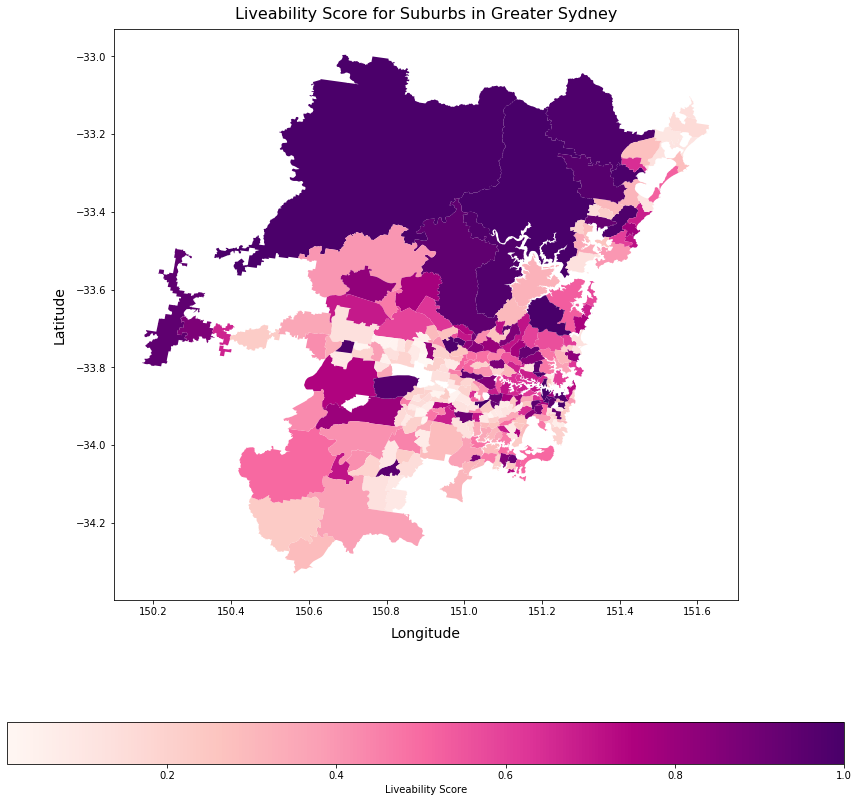

In [161]:
suburbs = gpd.read_postgis("SELECT sa2_name16, score, geom FROM sa2_scores", conn)
suburbs.plot(column='score', legend=True,figsize=(15, 15), cmap='RdPu',
             legend_kwds={'label': "Liveability Score",
                        'orientation': "horizontal"})
plt.title("Liveability Score for Suburbs in Greater Sydney", fontdict={'fontsize': 16}, pad=10)  # setting a title
plt.xlabel("Longitude", fontdict={'fontsize': 14}, labelpad=10)  # setting an x-axis
plt.ylabel("Latitude", fontdict={'fontsize': 14}, labelpad=10)  # setting a y-axis
plt.show()  # displaying the plot

## Correlation Testing

### Correlation between score and median household income; between score and average monthly rent

In [127]:
query(conn, """
    SELECT CORR(score, median_annual_household_income) AS "score_and_income_corr",
           CORR(score, avg_monthly_rent) AS "score_and_rent_corr"
    FROM sa2_scores JOIN neighbours ON (sa2_name16 = area_name)""")

,score_and_income_corr,score_and_rent_corr
0,0.241785,0.366409


# City Of Sydney

## Reading and Cleaning the Mobility Parking Dataset

In [162]:
parking = gpd.read_file('Mobility_parking.geojson')
parkingog = parking.copy()

columns_to_drop = ['Address', 'SiteID', 'Street', 'Location', 'SideOfStreet',
                   'URL', 'AuditDate', 'SignText', 'ParkingSpaceAngle', 'ParkingSpaceWidth',
                   'ParkingSpaceLength']
parking.drop(columns = columns_to_drop, inplace=True)

parking['geom'] = parking['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
parking.drop(columns='geometry', inplace=True)

#Testing for duplicate rows
if (parking.duplicated().sum() == 0):
    print("No duplicated rows")
else:
    print("Duplicated rows below")
    parking[parking.duplicated(keep=False)]

    
#Testing for Null values
if (parking.isnull().values.any() == False):
    print("No Null values")
else:
    print("Null rows below")
    parking[parking.isnull().any(axis=1)]
    

    
parking.rename(columns = {
    'OBJECTID' : 'objectid',
    'Suburb' : 'suburb',
    'NumberParkingSpaces' : 'numberparkingspaces',
}, inplace = True)

conn.execute("""
DROP TABLE IF EXISTS parking;
CREATE TABLE parking (
    objectid INT PRIMARY KEY,
    suburb VARCHAR(50),
    numberparkingspaces INT,
    geom GEOMETRY(POINTZ, 4283)
);""")

parking.to_sql("parking", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINTZ', srid)})

No duplicated rows
No Null values


## City of Sydney specific z scores

### Parking z score

In [163]:
query(conn, """
    DROP VIEW IF EXISTS parking_ratio CASCADE;
    CREATE VIEW parking_ratio AS
    select sa2_name16, SUM(numberparkingspaces) / AVG(land_area) AS "parkingperkmsq"
    from sa2 s 
        LEFT JOIN parking p ON ST_CONTAINS(s.geom, p.geom)
        JOIN Neighbours n ON (sa2_name16 = n.area_name)
    where sa3_name16 = 'Sydney Inner City'
    GROUP BY sa2_name16""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [164]:
query(conn, """
    DROP VIEW IF EXISTS parking_z CASCADE;
    CREATE VIEW parking_z AS
    SELECT sa2_name16, 
        (parkingperkmsq - (SELECT AVG(parkingperkmsq) FROM parking_ratio))
        / (SELECT STDDEV(parkingperkmsq) FROM parking_ratio) AS "parking_z"
    FROM parking_ratio""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


### Modified Accom, Retail and Health z score

In [165]:
query(conn, """
    DROP VIEW IF EXISTS buss_z_syd CASCADE;
    CREATE VIEW buss_z_syd AS
    SELECT sa2_name16, 
        (accom_ratio - (SELECT AVG(accom_ratio) FROM buss_ratio WHERE sa3_name16 = 'Sydney Inner City'))
        / (SELECT STDDEV(accom_ratio) FROM buss_ratio WHERE sa3_name16 = 'Sydney Inner City') AS "accom_z",
        
        (retail_ratio - (SELECT AVG(retail_ratio) FROM buss_ratio WHERE sa3_name16 = 'Sydney Inner City'))
        / (SELECT STDDEV(retail_ratio) FROM buss_ratio WHERE sa3_name16 = 'Sydney Inner City') AS "retail_z",
        
        (health_ratio - (SELECT AVG(health_ratio) FROM buss_ratio WHERE sa3_name16 = 'Sydney Inner City'))
        / (SELECT STDDEV(health_ratio) FROM buss_ratio WHERE sa3_name16 = 'Sydney Inner City') AS "health_z"
    
    FROM buss_ratio
    WHERE sa3_name16 = 'Sydney Inner City'
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


### Modified Catchment z score

In [166]:
query(conn, """
    DROP VIEW IF EXISTS catchment_z_view_syd CASCADE;
    CREATE VIEW catchment_z_view_syd AS
    SELECT sa2_name16, 
        (catchment_ratio - (SELECT AVG(catchment_ratio) FROM catchment_ratio_view 
                                WHERE sa3_name16 = 'Sydney Inner City'))
        / (SELECT STDDEV(catchment_ratio) FROM catchment_ratio_view
                WHERE sa3_name16 = 'Sydney Inner City') AS "catchment_z",
        geom
        
    FROM catchment_ratio_view
    WHERE sa3_name16 = 'Sydney Inner City'
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


### Modified Crime z score

In [167]:
query(conn, """
    DROP VIEW IF EXISTS Crime_z_syd CASCADE;
    CREATE VIEW Crime_z_syd AS
    SELECT sa2_name16,
        (crime_count - (SELECT AVG(crime_count) FROM CrimeTotal WHERE sa3_name16 = 'Sydney Inner City')) 
        / ((SELECT STDDEV(crime_count) FROM CrimeTotal WHERE sa3_name16 = 'Sydney Inner City')) AS "crime_z"
    
    FROM CrimeTotal
    WHERE sa3_name16 = 'Sydney Inner City'
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Modified Sigmoid for City of Sydney

In [168]:
query(conn, """
    DROP VIEW IF EXISTS sa2_scores_syd CASCADE;
    CREATE VIEW sa2_scores_syd AS
    SELECT sa2_name16, catchment_z, accom_z, retail_z, health_z, crime_z, parking_z,
            1/(1 + EXP(-1 * (2 * catchment_z + 0.5 * accom_z + 0.5 * retail_z + 3 * health_z - crime_z + 1.5 * parking_z))) AS "score",
            geom
    FROM catchment_z_view JOIN buss_z USING (sa2_name16)
        JOIN crime_z USING(sa2_name16)
        JOIN parking_z USING (sa2_name16)
""")

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


## Visualisation of Data

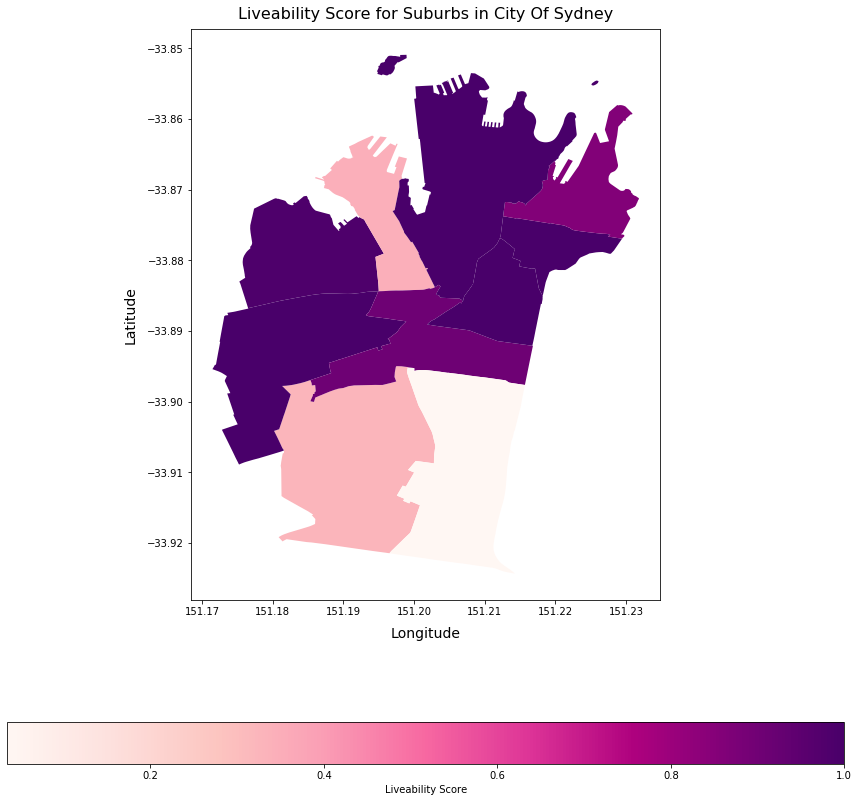

In [169]:
suburbs = gpd.read_postgis("SELECT sa2_name16, score, geom FROM sa2_scores_syd", conn)
suburbs.plot(column='score', legend=True,figsize=(15, 15), cmap='RdPu',
             legend_kwds={'label': "Liveability Score",
                        'orientation': "horizontal"})
plt.title("Liveability Score for Suburbs in City Of Sydney", fontdict={'fontsize': 16}, pad=10)  # setting a title
plt.xlabel("Longitude", fontdict={'fontsize': 14}, labelpad=10)  # setting an x-axis
plt.ylabel("Latitude", fontdict={'fontsize': 14}, labelpad=10)  # setting a y-axis
plt.show() 

### Top 3 SA2 in City of Sydney

In [183]:
suburbs.sort_values('score', ascending=False).head(3)

,sa2_name16,score,geom
8,Sydney - Haymarket - The Rocks,1.000000,"MULTIPOLYGON (((151.22538 -33.85527, 151.22524..."
0,Darlinghurst,1.000000,"MULTIPOLYGON (((151.21227 -33.87633, 151.21232..."
7,Surry Hills,0.999537,"MULTIPOLYGON (((151.20830 -33.88344, 151.20842..."


# ML Liveability Score

In [181]:
df = pd.read_sql_query('''
SELECT s.sa2_name16, score, number_of_businesses/land_area as "businesses_to_land", 
            avg_monthly_rent, health_care_and_social_assistance/land_area as "health_to_land", 
            (primary_count + secondary_count + future_count)/land_area as "catchments_to_land", 
            young_people/land_area as "young_area", 
            parkingperkmsq/land_area as "parking_area",
            (SELECT SUM(crime)
             FROM CrimeCount c 
             WHERE s.sa2_name16 = c.sa2_name16) as "total_crime"
    FROM sa2_scores_syd s JOIN neighbours n ON n.area_name = s.sa2_name16 
        JOIN busstat b ON b.area_name = n.area_name 
        JOIN parking_ratio p ON n.area_name = p.sa2_name16 
        JOIN catchment_count cc ON n.area_name = cc.sa2_name16
''', conn)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Data
df_data = df.drop(df.columns[[0, 1]], axis=1)  # df.columns is zero-based pd.Index
df_data = df_data.to_numpy()

score = df['score'].to_numpy()

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    df_data, score, random_state=0)

# Normalise the data
# Calculate min and max based on the training data, use them on the test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test) 

# Define grid search parameters for KNN
# k - number of nearest neighbors
# p - distance measure, p=2: Euclidean, p=1: Manhattan
param_grid = {'n_neighbors': [1, 3, 5],
              'p': [1, 2]}
print("Parameter grid:\n{}".format(param_grid))

# Use grid search with cross validation to find the best set of parameters
# Uses 7 fold cross validation (7 samples in training data)
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=7,
                          return_train_score=True, scoring='neg_mean_squared_error')
 
# Find the best model parameters on training set using mean squared error
grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross validation score on training set: {:.2f}".format(grid_search.best_score_*-1))

# Use the best parameters to evaluate model performance on test set
print("Score on test set with best parameters: {:.2f}".format(grid_search.score(X_test, y_test)*-1))


Parameter grid:
{'n_neighbors': [1, 3, 5], 'p': [1, 2]}
Best parameters: {'n_neighbors': 5, 'p': 1}
Best cross validation score on training set: 0.20
Score on test set with best parameters: 0.09


## Closing Connection

In [184]:
conn.close()
db.dispose()